# Sentiment Classification Using RNN, LSTM, LSTM Word2Vec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy==1.25.0 # Setting the numpy version to 1.25.0
!pip install gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2


In [ ]:
import numpy as np
print(np.__version__) # Checking numpy version

1.25.0


In [ ]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

#### Loading the dataset

In [ ]:
# dataset path for racist/sexist dataset
dataset_path = "/content/drive/MyDrive/Sem6/AI_ML/assignment_dataset/text_classification/train_racisit.csv"
df = pd.read_csv(dataset_path)

In [ ]:
df.head() # first 5 records in dataset

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
df.isnull().any() # Cheecking for null vslues

,0
id,False
label,False
tweet,False


In [ ]:
# Defining a text cleaning function to clean the content in dataset

def text_cleaning_pipeline(dataset, rule):

  # Convert the input to small/lower order.
  data = dataset.lower()
  # Remove URLs
  data = re.sub(r"http\S+|www\S+|https\S+", '',data, flags=re.MULTILINE)
  # Remove emojis
  data = re.sub(r"["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags
                        u"\u2702-\u27B0"          # dingbats
                        u"\u24C2-\U0001F251"      # enclosed characters
                        "]+",
                        r' ', data, flags=re.UNICODE)
  # Remove mentions
  data = re.sub("@[A-Za-z0-9_]+"," ", data)
  # Remove all other unwanted characters.
  data = re.sub("[^0-9A-Za-z ]", "" , data)
  # Create tokens.
  tokens = data.split()
  # Remove stopwords:
  stop_words = set(stopwords.words('english'))
  result_tokens = []
  for token in tokens:
    if token not in stop_words:
      result_tokens.append(token)
  if rule == "lemmatize":
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in result_tokens]
  elif rule == "stem":
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in result_tokens]
  else:
    print("Pick between lemmatize or stem")


  return " ".join(tokens)


In [ ]:
df['clean_tweet'] = df['tweet'].apply(lambda x: text_cleaning_pipeline(x, rule="lemmatize")) # Cleaning the text with lemmatization rule

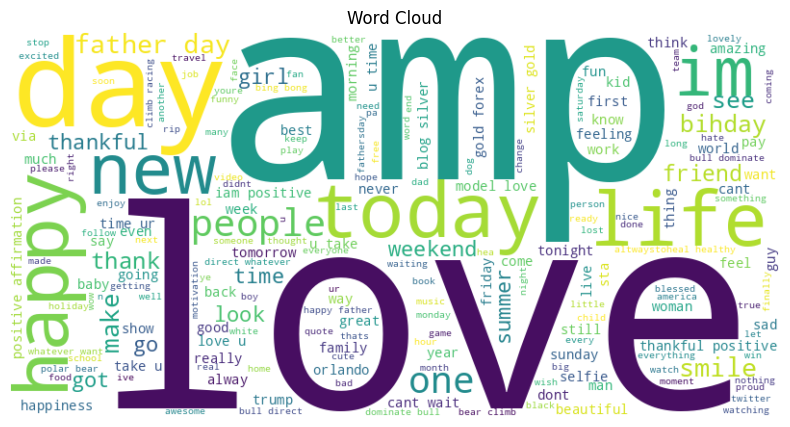

In [ ]:
# Word Cloud graph of the frequently used words in dataset
all_clean_text = " ".join(df['clean_tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_clean_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

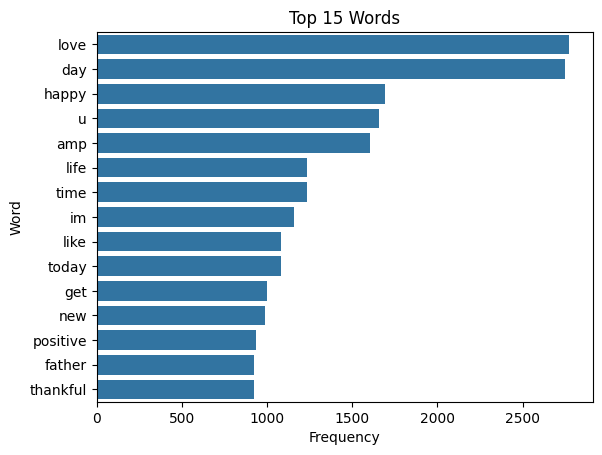

In [ ]:
# Top 15 words in the dataset
word_freq = Counter(" ".join(df["clean_tweet"]).split())
common_words = pd.DataFrame(word_freq.most_common(15), columns=['Word', 'Frequency'])
sns.barplot(data=common_words, x='Frequency', y='Word')
plt.title("Top 15 Words")
plt.show()

In [ ]:
# TOKENIZATION + PADDING
X = df['clean_tweet'].values
y = df['label'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size: ",vocab_size)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

max_len = int(np.percentile([len(x) for x in X_train_seq], 95))
print("\nMax Length: ",max_len)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

Vocab size:  33695

Max Length:  13


In [ ]:
# Function to visualize plots of train and validation loss/accuracy
def plot_visualization(model_history, model_name):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(model_history.history['loss'], label='Training Loss')
  plt.plot(model_history.history['val_loss'], label='Validation Loss')
  plt.title(f'{model_name}: Training vs Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(model_history.history['accuracy'], label='Training Accuracy')
  plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{model_name}: Training vs Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
# function to get evaluation of model, confusion matrix and classification report
def evaluate_model(model, model_name):
  loss, accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
  print('Test Loss:', loss)
  print('\nTest Accuracy:', accuracy)
  y_pred = (model.predict(X_val_pad) > 0.5).astype(int)
  print(f"\n\n{model_name} Accuracy: {accuracy_score(y_val, y_pred):.4f}")
  print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
  print("Classification Report:\n", classification_report(y_val, y_pred))

In [ ]:
# Setting the methods to avoid model overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

### Model 1: Simple RNN

In [ ]:
# Architecture of model1: Simple RNN
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.build(input_shape=(None, max_len))
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 13, 64)         │     2,156,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,164,801 (8.26 MB)

 Trainable params: 2,164,801 (8.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1_history = model1.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9231 - loss: 0.2505

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9232 - loss: 0.2503 - val_accuracy: 0.9585 - val_loss: 0.1288
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9849 - loss: 0.0527 - val_accuracy: 0.9510 - val_loss: 0.1445
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9958 - loss: 0.0152 - val_accuracy: 0.9550 - val_loss: 0.1666
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9982 - loss: 0.0068 - val_accuracy: 0.9567 - val_loss: 0.1745
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9551 - val_loss: 0.1923


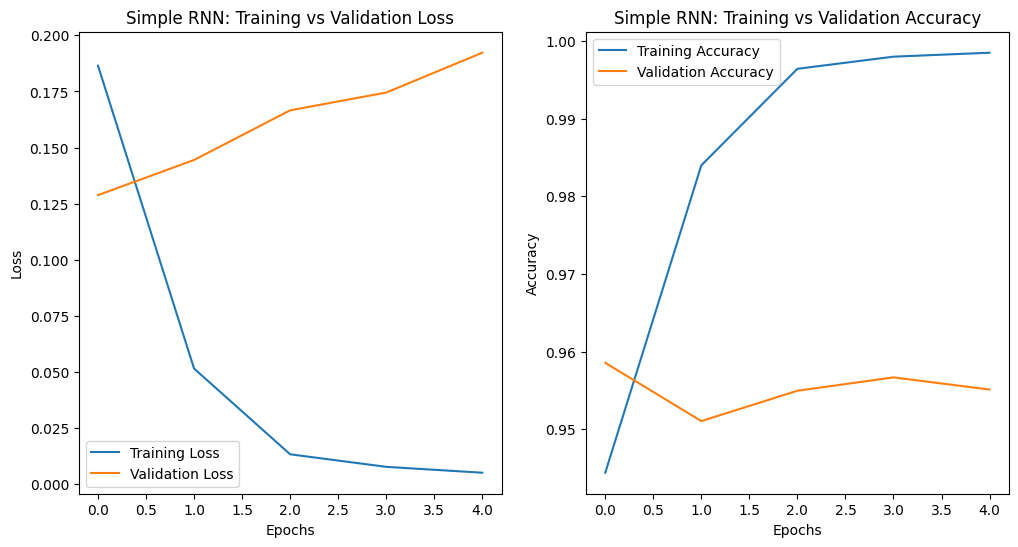

In [ ]:
plot_visualization(model1_history, "Simple RNN")

In [ ]:
evaluate_model(model1, "Simple RNN")

Test Loss: 0.12881776690483093

Test Accuracy: 0.9585484266281128
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Simple RNN Accuracy: 0.9585
Confusion Matrix:
 [[5870   67]
 [ 198  258]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.79      0.57      0.66       456

    accuracy                           0.96      6393
   macro avg       0.88      0.78      0.82      6393
weighted avg       0.95      0.96      0.96      6393



In [ ]:
model1.save('model1.h5')

### Model 2: LSTM with a trainable Embedding layer

In [ ]:
# Architecture of model 2: LSTM with trainable embedding
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.build(input_shape=(None, max_len))
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 13, 64)         │     2,156,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,189,569 (8.35 MB)

 Trainable params: 2,189,569 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2_history = model2.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9259 - loss: 0.2555

400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9260 - loss: 0.2551 - val_accuracy: 0.9593 - val_loss: 0.1226
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9790 - loss: 0.0656

400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9790 - loss: 0.0656 - val_accuracy: 0.9634 - val_loss: 0.1192
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9916 - loss: 0.0299 - val_accuracy: 0.9568 - val_loss: 0.1396
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9958 - loss: 0.0152 - val_accuracy: 0.9593 - val_loss: 0.1734
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9972 - loss: 0.0095 - val_accuracy: 0.9553 - val_loss: 0.2121
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9985 - loss: 0.0078 - val_accuracy: 0.9604 - val_loss: 0.1952


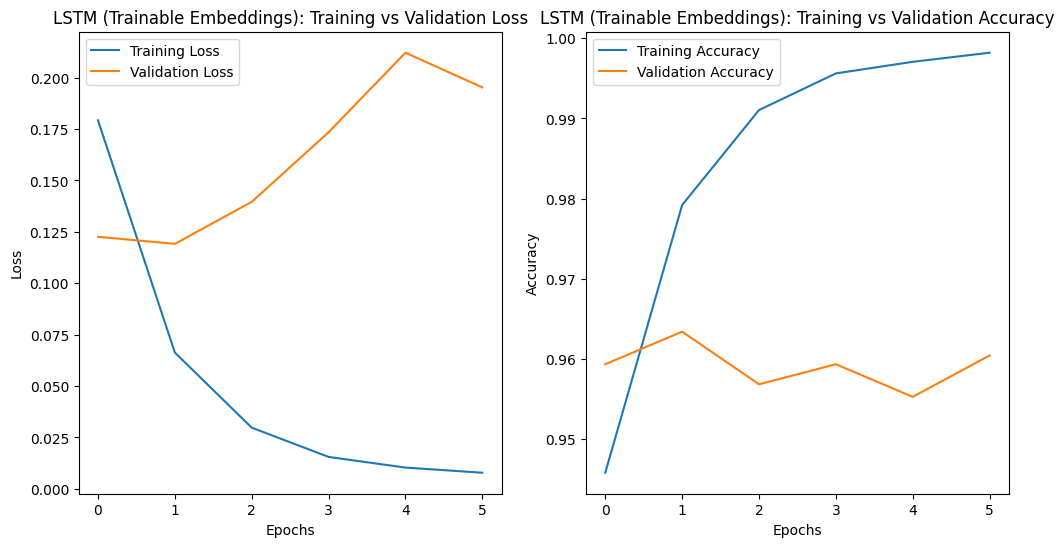

In [ ]:
plot_visualization(model2_history, "LSTM (Trainable Embeddings)")

In [ ]:
evaluate_model(model2, "LSTM (Trainable Embeddings)")

Test Loss: 0.11915867775678635

Test Accuracy: 0.9633974432945251
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


LSTM (Trainable Embeddings) Accuracy: 0.9634
Confusion Matrix:
 [[5875   62]
 [ 172  284]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.82      0.62      0.71       456

    accuracy                           0.96      6393
   macro avg       0.90      0.81      0.84      6393
weighted avg       0.96      0.96      0.96      6393



In [ ]:
model2.save('model2.h5')

### Model 3: LSTM with pretrained Word2Vec embeddings

In [ ]:
import gensim.downloader as api

In [ ]:
import numpy as np

In [ ]:
# Downloading the pretrained W2V Embedding (Used glove-wiki-gigaword-50)

embedding_model = api.load('glove-wiki-gigaword-50')
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
# Model 3 Architecture: LSTM with Word2Vector embedding on pretrained embedding
model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,684,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,684,750 (6.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,684,750 (6.43 MB)

In [ ]:
model3_history = model3.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9136 - loss: 0.2666 - val_accuracy: 0.9415 - val_loss: 0.1686
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9454 - loss: 0.1558 - val_accuracy: 0.9465 - val_loss: 0.1530
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9497 - loss: 0.1417 - val_accuracy: 0.9467 - val_loss: 0.1476
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9579 - loss: 0.1236 - val_accuracy: 0.9501 - val_loss: 0.1450
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9634 - loss: 0.1072 - val_accuracy: 0.9496 - val_loss: 0.1441
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9618 - loss: 0.1056 - val_accuracy: 0.9471 - val_loss: 0.1470
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9690 - loss: 0.0960 - val_accuracy: 0.9509 - val_loss: 0.1432
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9704 - loss: 0.0907 - val_accuracy: 0

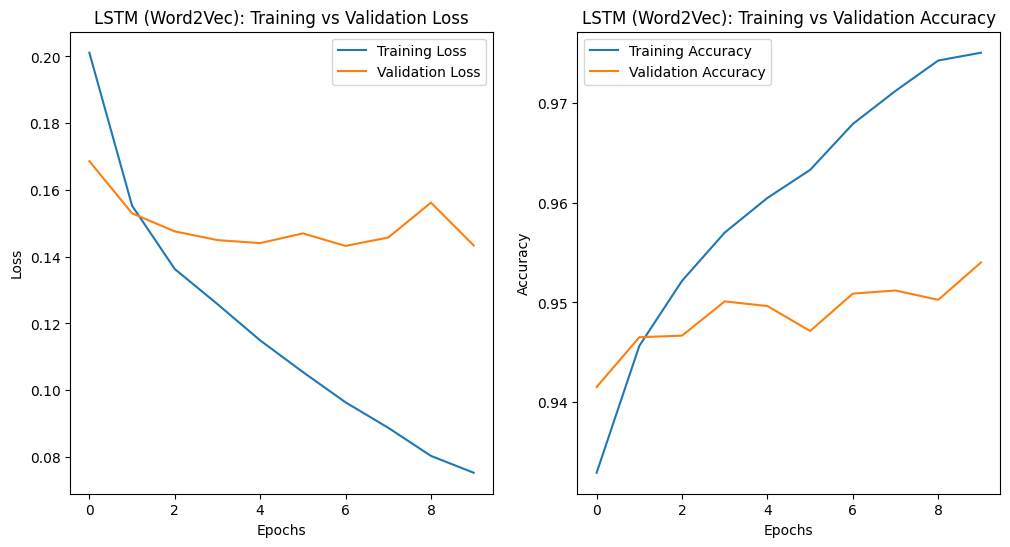

In [ ]:
plot_visualization(model3_history, "LSTM (Word2Vec)")

In [ ]:
evaluate_model(model3, "LSTM (Word2Vec)")

Test Loss: 0.14321473240852356

Test Accuracy: 0.9508838057518005
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


LSTM (Word2Vec) Accuracy: 0.9509
Confusion Matrix:
 [[5850   87]
 [ 227  229]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      5937
           1       0.72      0.50      0.59       456

    accuracy                           0.95      6393
   macro avg       0.84      0.74      0.78      6393
weighted avg       0.95      0.95      0.95      6393



In [ ]:
model3.save('model3.h5')

### Predictions of model

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean the input text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|\d+", '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r"\b(?:{})\b".format('|'.join(stop_words)), '', text)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text.strip()


In [ ]:
# Predicting the result on custom input text provided
def predict_text(model, model_name, text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad)[0][0]
    sentiment = 'Racist/Sexist' if pred > 0.5 else 'Not Racist/Sexist'
    print(f"\nPrediction made by model: {model_name}\n")
    print(f"Text: {text}\nPrediction: {sentiment} ({pred:.3f})")

In [ ]:
# Model 1 Prediction
predict_text(model1, "Simple RNN", "@user @user @user i will never understand why my dad left me when i was so young.... :/ #deep #inthefeels")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step

Prediction made by model: Simple RNN

Text: @user @user @user i will never understand why my dad left me when i was so young.... :/ #deep #inthefeels
Prediction: Not Racist/Sexist (0.039)


In [ ]:
# Model 2 Prediction
predict_text(model2, "LSTM (Trainable Embeddings)", "my granddaughter's 1st bihday is tomorrow.  going to pick her play house, little car, &amp; pool today.   ððððððð")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Prediction made by model: LSTM (Trainable Embeddings)

Text: my granddaughter's 1st bihday is tomorrow.  going to pick her play house, little car, &amp; pool today.   ððððððð
Prediction: Not Racist/Sexist (0.001)


In [ ]:
# Model 3 Prediction
predict_text(model3, "LSTM (Word2Vec)", "my granddaughter's 1st bihday is tomorrow.  going to pick her play house, little car, &amp; pool today.   ððððððð")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Prediction made by model: LSTM (Word2Vec)

Text: my granddaughter's 1st bihday is tomorrow.  going to pick her play house, little car, &amp; pool today.   ððððððð
Prediction: Not Racist/Sexist (0.001)


In [ ]:
import pickle

# Save tokenizer for later use
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Realtime Analyzer

At the end of the project, a simple stramlit application is designed to show the prediction on real time with the help of Streamlit. The link to the web page is as follows:

https://tweet-analysis-6cs012.streamlit.app/

THE END